<a href="https://colab.research.google.com/github/valenottaviano/BNN-Air-quality/blob/main/Bayesian_Nerual_Network_with_TF_Probabilistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load libriaries and functions.import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest# Define helper functions.scaler = StandardScaler()
import seaborn as sns
import matplotlib.pyplot as plt

detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AirQualityUCI.csv', delimiter=';', index_col="Date")

raw_data.index = pd.to_datetime(raw_data.index.values)
dataset = raw_data.resample("D").mean()
dataset = dataset.iloc[:-200, :-2]
dataset.dropna(axis=0, how='any', inplace=True)
columns = dataset.columns

# Define helper functions.

scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

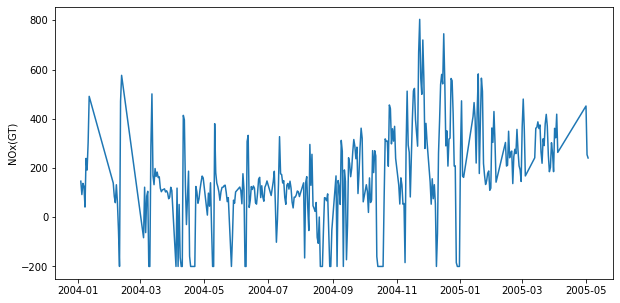

In [ ]:
dataset['NOx(GT)'] = dataset['NOx(GT)'].dropna(axis=0)

plt.figure(figsize=(10,5))
sns.lineplot(data=dataset, x=dataset.index.values, y=dataset['NOx(GT)'])
plt.show()

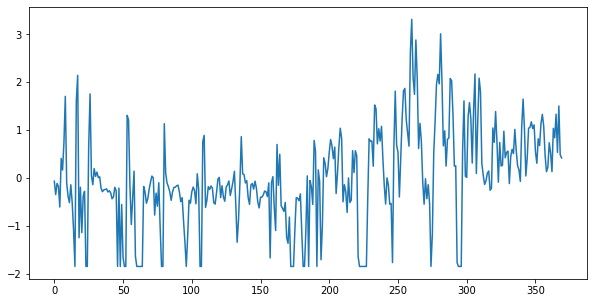

In [ ]:
dataset_transformed = scaler.fit_transform(dataset)

plt.figure(figsize=(10,5))
plt.plot(dataset_transformed[:,3])
plt.show()

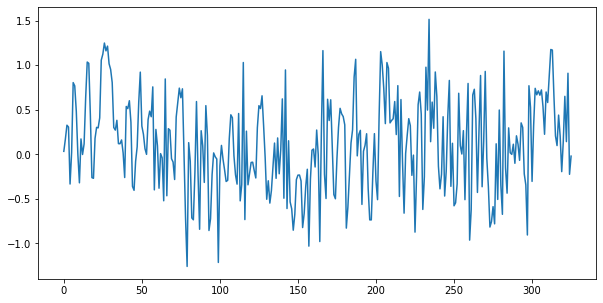

In [ ]:
is_inlier = detector.fit_predict(dataset_transformed)
dataset_transformed_inliers = dataset_transformed[(is_inlier > 0),:]

plt.figure(figsize=(10,5))
plt.plot(dataset_transformed_inliers[:, 0])
plt.show()

In [ ]:
dataset_restored = pd.DataFrame(data=dataset_transformed_inliers, columns=columns)
dataset_restored.head()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,0.033328,3.674446,-0.196008,-0.067729,-0.264204,0.298538,-0.005389,0.025874
1,0.171006,-0.188249,0.043147,-0.346480,0.476010,0.187945,0.603117,-0.228872
2,0.326745,-0.344162,0.517076,-0.113366,0.384646,0.102653,1.250564,0.276984
3,0.306298,-0.344162,0.590100,-0.174216,-0.284230,0.455247,1.177382,0.254132
4,-0.333357,-0.344162,-0.487559,-0.607663,0.312949,-0.060176,0.384466,-0.958182


In [ ]:
# Select labels for inputs and outputs.
inputs = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S4(NO2)", "PT08.S5(O3)"]
outputs = ["NOx(GT)"]


# Define some hyperparameters.
n_epochs = 50
n_samples = dataset_restored.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset_restored.shape[0])

In [ ]:

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset_restored[inputs].values, dataset_restored[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [ ]:

# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)


model = tfk.Sequential([
  tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
  tfp.layers.DenseFlipout(10, activation="relu", name="dense_1"),
  tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
                len(outputs)), activation=None, name="distribution_weights"),
  tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")



# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

# Run training session.
history = model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=0)

# Describe model.
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (DenseFlipout)       (None, 10)                90        
_________________________________________________________________
distribution_weights (Dense) (None, 2)                 22        
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________


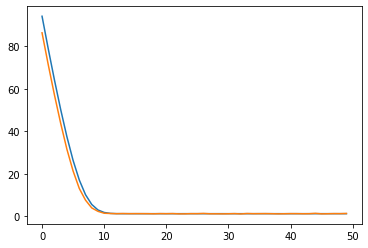

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
# Predict.
samples = 10
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)


In [ ]:
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(shape=(samples, len(outputs), iterations))

for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)

# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

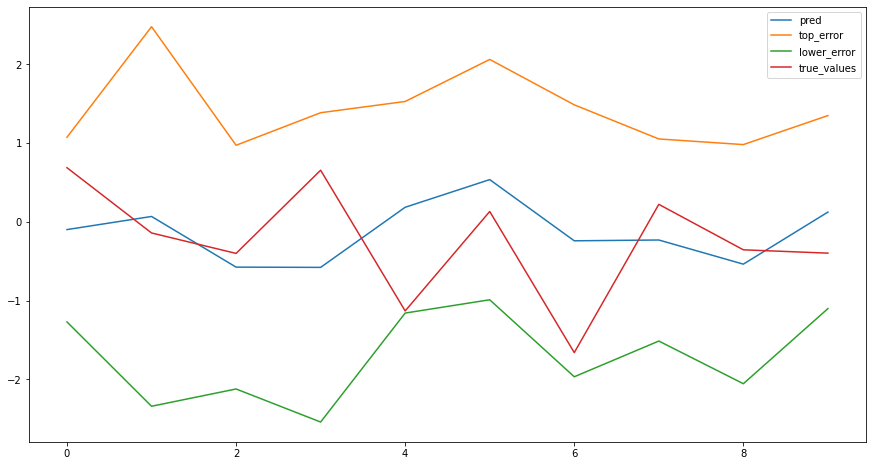

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(Y_pred_m, label='pred')
plt.plot((Y_pred_m + Y_pred_s*1.96), label='top_error')
plt.plot((Y_pred_m - Y_pred_s*1.96), label='lower_error')
plt.plot(Y_true, label='true_values')
plt.legend()
plt.show()